# Setup

In [2]:
!pip install xgboost > /dev/null

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import xgboost as xgb

from xgboost.callback import EvaluationMonitor

In [5]:
pd_clean_train = pd.read_csv("./data/clean/train.csv", index_col='PassengerId')
pd_clean_test = pd.read_csv("./data/clean/test.csv", index_col='PassengerId')
pd_sample_submission = pd.read_csv("../input/sample_submission.csv")

In [86]:
pd_clean_train.info()
pd_clean_train.head(1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Pclass    100000 non-null  int64  
 1   Sex       100000 non-null  object 
 2   Age       96708 non-null   float64
 3   SibSp     100000 non-null  int64  
 4   Parch     100000 non-null  int64  
 5   Fare      99866 non-null   float64
 6   Embarked  99750 non-null   object 
 7   Survived  100000 non-null  int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 6.9+ MB


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
PassengerId,,,,,,,,
0,1,male,NaN,2,0,27.14,S,1


# Create Modeling Datasets

In [87]:
def format_dataset(pd_df):
    dataset_cols = [
        'Pclass',
        'Sex',
        'Age',
        'SibSp',
        'Parch',
        'Fare',
        'Embarked',
        'Survived']
    
    return pd_df.loc[:, [col for col in dataset_cols if col in pd_df.columns]]


def one_hot_encode(pd_df):
    pd_df = pd.get_dummies(pd_df, columns=['Sex', 'Embarked'], dummy_na=True)
    pd_df = pd_df.drop('Sex_nan', axis=1)  # no null values exist in training or test set
    
    return pd_df

In [88]:
pd_model_train = (pd_clean_train
    .pipe(format_dataset)
    .pipe(one_hot_encode))
pd_model_test = (pd_clean_test
    .pipe(format_dataset)
    .pipe(one_hot_encode))

In [89]:
pd_model.head(1)

,Pclass,Age,SibSp,Parch,Fare,Survived,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan
PassengerId,,,,,,,,,,,,
0,1,NaN,2,0,27.14,1,0,1,0,0,1,0


# Train-Validation Split

In [ ]:
pd_train = pd_model_train.sample(frac = 0.8, random_state=3)
pd_valid = pd_model_train.drop(pd_train.index)

# Train Model

In [56]:
# Train setup
X_train = pd_train.drop('Survived', axis=1)
X_valid = pd_valid.drop('Survived', axis=1)
y_train = pd_train.Survived
y_valid = pd_valid.Survived

clf = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.7,
    reg_lambda=1,
    random_state=3,
    tree_method='hist',
    use_label_encoder=False)

In [57]:
%%time
clf.fit(
    X=X_train, 
    y=y_train, 
    verbose=False,
    eval_metric=['logloss', 'error'],
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    callbacks=[EvaluationMonitor(period=25)])

[0]	validation_0-logloss:0.67615	validation_0-error:0.23266	validation_1-logloss:0.67641	validation_1-error:0.23860
[25]	validation_0-logloss:0.51171	validation_0-error:0.22796	validation_1-logloss:0.51639	validation_1-error:0.23530
[50]	validation_0-logloss:0.48713	validation_0-error:0.22581	validation_1-logloss:0.49385	validation_1-error:0.23075
[75]	validation_0-logloss:0.48159	validation_0-error:0.22461	validation_1-logloss:0.49009	validation_1-error:0.23060
[100]	validation_0-logloss:0.47917	validation_0-error:0.22373	validation_1-logloss:0.48881	validation_1-error:0.23060
[125]	validation_0-logloss:0.47742	validation_0-error:0.22319	validation_1-logloss:0.48842	validation_1-error:0.23025
[150]	validation_0-logloss:0.47632	validation_0-error:0.22271	validation_1-logloss:0.48824	validation_1-error:0.22965
[175]	validation_0-logloss:0.47533	validation_0-error:0.22195	validation_1-logloss:0.48821	validation_1-error:0.22935
[199]	validation_0-logloss:0.47439	validation_0-error:0.22096

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=8, num_parallel_tree=1,
              objective='binary:logistic', random_state=3, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.9,
              tree_method='hist', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

# Evaluate Model

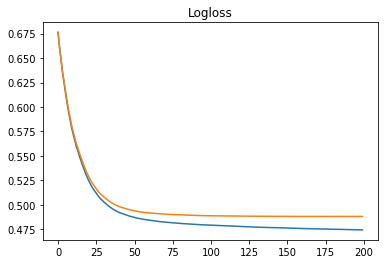

Minimum: 0.488126 (n_trees=186)


In [58]:
train_logloss = clf.evals_result()['validation_0']['logloss']
valid_logloss = clf.evals_result()['validation_1']['logloss']
plt.plot(train_logloss)
plt.plot(valid_logloss)
plt.title("Logloss")
plt.show()

srs_valid = pd.Series(valid_logloss)
print("Minimum: {} (n_trees={})".format(
    srs_valid[srs_valid.idxmin()], srs_valid.idxmin() + 1))

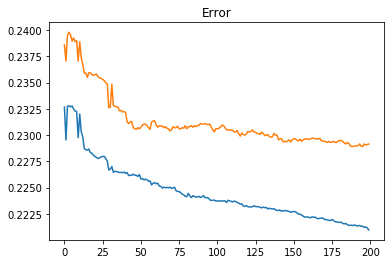

Minimum: 0.2289 (n_trees=189)


In [59]:
train_error = clf.evals_result()['validation_0']['error']
valid_error = clf.evals_result()['validation_1']['error']
plt.plot(train_error)
plt.plot(valid_error)
plt.title("Error")
plt.show()

srs_valid = pd.Series(valid_error)
print("Minimum: {} (n_trees={})".format(
    srs_valid[srs_valid.idxmin()], srs_valid.idxmin() + 1))

# Create Submission

In [70]:
# Update parameters
best_n_estimators = 189
clf = clf.set_params(**{'n_estimators': best_n_estimators})

In [80]:
%%time
X = pd.concat([X_train, X_valid])
y = y_train.append(y_valid)

clf.fit(
    X=X, 
    y=y, 
    verbose=False,
    eval_metric=['logloss', 'error'],
    eval_set=[(X, y)],
    callbacks=[EvaluationMonitor(period=25)])

[0]	validation_0-logloss:0.67624	validation_0-error:0.23511
[25]	validation_0-logloss:0.51284	validation_0-error:0.22861
[50]	validation_0-logloss:0.48848	validation_0-error:0.22684
[75]	validation_0-logloss:0.48322	validation_0-error:0.22579
[100]	validation_0-logloss:0.48114	validation_0-error:0.22487
[125]	validation_0-logloss:0.47969	validation_0-error:0.22434
[150]	validation_0-logloss:0.47867	validation_0-error:0.22369
[175]	validation_0-logloss:0.47776	validation_0-error:0.22329
[188]	validation_0-logloss:0.47731	validation_0-error:0.22275
CPU times: user 10.1 s, sys: 79.3 ms, total: 10.2 s
Wall time: 1.29 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=189, n_jobs=8, num_parallel_tree=1,
              objective='binary:logistic', random_state=3, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.9,
              tree_method='hist', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [102]:
# Create sumbission dataset
predictions = clf.predict(pd_model_test)
pd_submission = pd_sample_submission.assign(Survived=predictions)
pd_submission.to_csv('./submissions/2.0-modelling-xgboost.csv', index=False)

In [104]:
# Submit
#!kaggle competitions submit -c tabular-playground-series-apr-2021 -f 2.0-modelling-xgboost-sub.csv.csv -m "2.0-modellng-xgboost-sub"

/bin/sh: 1: kaggle: not found
